## Setup

In [1]:
!pip install geopandas 
!pip install matplotlib==3.1.3
import matplotlib as plt
!pip install networkx== 2.8
!pip install numpy== 1.23
import numpy as np
!pip install pandas==1.5
import pandas as pd 
!pip install pyproj==3.4
!pip install Shapely==1.7

!pip install osmnx
import osmnx as ox

In [ ]:
import warnings
try:
    import geopy
except ModuleNotFoundError as e:
    %pip install geopy==2.2.0
    import geopy
if geopy.__version__ != "2.2.0":
    !pip install -U geopy==2.2.0
    import geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 5.0 MB/s eta 0:00:00
  Attempting uninstall: geopy
    Found existing installation: geopy 1.17.0
    Uninstalling geopy-1.17.0:
      Successfully uninstalled geopy-1.17.0


In [2]:
try:
  import pyrosm
except ModuleNotFoundError as e:
  %pip install pyrosm
  import pyrosm

In [ ]:
import requests
import fiona
import urllib
import os
import zipfile, io
import urllib3
import ssl
import matplotlib.pyplot as plt
import networkx as nx
from geopy.geocoders import Nominatim
import networkx as nx
from datetime import datetime
from bs4 import BeautifulSoup
from datetime import datetime, timedelta, date
from geopandas import GeoDataFrame
from shapely.geometry import Point
from pyrosm import OSM
from pyrosm import get_data
from google.colab import files
import geopandas as gpd


In [ ]:

class CustomHttpAdapter(requests.adapters.HTTPAdapter):
  def __init__(self, ssl_context=None, **kwargs):
    self.ssl_context = ssl_context
    super().__init__(**kwargs)

  def init_poolmanager(self, connections, maxsize, block=False):
    self.poolmanager = urllib3.poolmanager.PoolManager(num_pools=connections, maxsize=maxsize, block=block, ssl_context=self.ssl_context)

def get_legacy_session():
  ctx = ssl.create_default_context(ssl.Purpose.SERVER_AUTH)
  ctx.options |= 0x4  
  session = requests.session()
  session.mount('https://', CustomHttpAdapter(ctx))
  return session

def download_file(url):
# source: https://stackoverflow.com/a/33488338
  local_filename = url.split('/')[-1]
  with get_legacy_session() as s:
    r = s.get(url, stream=True)
    r.raw.decode_content = True
    with open(local_filename, 'wb') as f:
      shutil.copyfileobj(r.raw, f)
  return local_filename

In [ ]:
if not os.path.exists('Limiti01012022'):
    zip_file_url = 'https://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/Limiti01012022.zip'
    zip_file_name = "Limiti01012022.zip"
    
    try: 
      urllib.request.urlretrieve(zip_file_url ,zip_file_name) 
    
    except:
      zip_file_name = download_file(zip_file_url)

    z = zipfile.ZipFile(zip_file_name)
    # unzip the file
    z.extractall()

In [ ]:
os.listdir('Limiti01012022')
os.chdir('Limiti01012022')
os.chdir('Com01012022')

for root, dirs, files in os.walk("."):  
    for filename in files:
        print(filename)

cities=gpd.read_file('Com01012022_WGS84.shp')

Com01012022_WGS84.shx
Com01012022_WGS84.prj
Com01012022_WGS84.shp
Com01012022_WGS84.dbf


## Start

In [ ]:
start = input("Starting address: ")
point_1 = gpd.tools.geocode(start, provider="arcgis")  


Starting address: Sassuolo


In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises")
location = geolocator.reverse(str(float(point_1.geometry.y))+","+ str(float(point_1.geometry.x)))

start_address = location.raw['address']

if start_address['country'] != 'Italia':
  print('Restart! Not an italian city')
print('Provincia:', start_address['county'])

Provincia: Modena


In [ ]:
if 'town' in start_address:
  area = start_address['town'] + ', '+start_address['county'] + ', Italy'
  city = start_address['town']
elif 'city' in start_address:
  area = start_address['city'] + ', '+start_address['county'] + ', Italy'
  city = start_address['city']

In [ ]:
G = ox.graph_from_place(area, network_type='all') #Only need to be ran once.

In [ ]:
area = start_address['county']
point_nearest_start = ox.distance.nearest_nodes(G,Y=location[1][0], X=location[1][1])

## End

In [ ]:
end = input("Destination: ")
point_2 = gpd.tools.geocode(end, provider="arcgis")

Destination: Modena


In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises")
location2 = geolocator.reverse(str(float(point_2.geometry.y))+","+ str(float(point_2.geometry.x)))

end_address = location2.raw['address']

In [ ]:
if 'town' in end_address:
  area = end_address['town'] + ', '+end_address['county'] + ', Italy'
  city = end_address['town']
elif 'city' in end_address:
  area = end_address['city'] + ', '+end_address['county'] + ', Italy'
  city = end_address['city']

In [ ]:
if start_address['county'] !=  end_address['county']:
  print('Not from the same province!')

In [ ]:
point_nearest_end = ox.distance.nearest_nodes(G, Y=location2[1][0], X=location2[1][1])

In [ ]:
G = ox.graph_from_place(end_address['county'], network_type='drive') #Only need to be ran once.
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [ ]:
shortest_path_distance = ox.shortest_path(G, point_nearest_start, point_nearest_end, weight='length')
travel_time = nx.shortest_path_length(G, point_nearest_start, point_nearest_end, weight='travel_time')
minutes = travel_time // 60 
seconds = round(travel_time % 60*0.6)

km_distance = round(nx.shortest_path_length(G, point_nearest_start, point_nearest_end, weight='length')/1000, 3)

In [ ]:
h_minute_time = round(km_distance*60//100)
h_seconds_time = round((km_distance * 60) % 100*0.6)
h_time= str(h_minute_time) + ' minutes, ' + str(h_seconds_time) + ' seconds '

f_minute_time = round(km_distance*60//70)
f_seconds_time = round((km_distance * 60) % 65*0.6)
f_time= str(f_minute_time) + ' minutes, ' + str(f_seconds_time) + ' seconds '

price = round(1.65/15 * km_distance,2)
f_cost = price
h_cost = price + round(0.09*km_distance,2)

print('Distance: ', km_distance,'km')
print('Car travel information:\nHighway price = ', h_cost, '€', '; Highway time =', h_time)
print('Freeway price = ', f_cost,'€ ; Freeway time = ', f_time)

Distance:  18.0 km
Car travel information:
Highway price =  3.6 € ; Highway time = 10 minutes, 48 seconds 
Freeway price =  1.98 € ; Freeway time =  15 minutes, 24 seconds 


## Accomodation

In [ ]:
days = int(input('How many days? '))
counter = int(input('how many of you are staying? '))

in_Month = datetime.now().month
in_Year = datetime.now().year
in_day = datetime.now().day

EndDate = datetime.now() + timedelta(days=days)
out_month =  EndDate.month
out_Year = EndDate.year
out_day = EndDate.day

How many days? 2
how many of you are staying? 2


In [ ]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36"}
url = "https://www.booking.com/searchresults.it.html?checkin_month={in_month}&checkin_monthday={in_day}&checkin_year={in_year}&checkout_month={out_month}&checkout_monthday={out_day}&checkout_year={out_year}&group_adults={people}&group_children=0&order=price&ss={city}%2C%20{country}"\
.format(in_month=in_Month,
       in_day=in_day,
       in_year = in_Year,
       out_month=out_month,
       out_day=out_day,
       out_year=out_Year,
       people=counter,
       city=city,
       country='Italia')

In [ ]:
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "lxml")


In [ ]:
prices = soup.find_all("div", class_ ="e6e585da68")
prices_list = [price.get_text().split("\n") for price in prices]

prcs = []
final_prices = dict()
t = 1
while t < len(prices_list):
  if any(map(str.isdigit, prices_list[t][0])) == True:
    prcs.append(prices_list[t][0][-4:])
  t+=1
for i in range(len(prcs)):
    final_prices[i] = prcs[i].replace('$','')
    final_prices[i] = prcs[i].replace(' ','')
    final_prices[i] = final_prices[i].replace('S','')
    final_prices[i] = final_prices[i].replace('.','')
final_prices = pd.DataFrame(final_prices, index=["Price"]).T
final_prices['Price'] = final_prices['Price'].str.replace('$','')

IDs = [i for i in range(len(final_prices['Price']))]
final_prices["ID"] = IDs

names = soup.find_all("div", class_ ="fcab3ed991 a23c043802")
name_list = [name.get_text().split("\n") for name in names]
Hotels = []
for i in name_list:
  Hotels.append(i[0])

final_prices['Hotels'] = Hotels
h_list = [i + ', '+ city for i in final_prices.Hotels]
Hotel_data = gpd.tools.geocode(h_list, provider="arcgis")
Hotel_data['ID'] = final_prices['ID']
Hotel_data = Hotel_data.merge(final_prices, on ='ID')
Hotel_data['lon'] = Hotel_data.geometry.x
Hotel_data['lat'] = Hotel_data.geometry.y
Hotel_data = Hotel_data.drop(['ID','geometry','address'], axis=1)
Hotel_data['Price'] = Hotel_data['Price'].str.replace("\xa0", "")
Hotel_data['Price'] = pd.to_numeric(Hotel_data['Price'])
Hotel_data.to_csv('hotels.csv', index =False)

<ipython-input-228-d317496b5c7e>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_prices['Price'] = final_prices['Price'].str.replace('$','')


In [ ]:
print('Mean accomodation cost:', Hotel_data['Price'].mean(), '€')

Mean accomodation cost: 226.08 €


In [ ]:
highway_cost = round(Hotel_data['Price'].mean() + h_cost, 3)
freeway_cost = round(Hotel_data['Price'].mean() + f_cost, 3)

print('Estimated cost if using freeway: ', highway_cost, '€',  'for ', days,'days and', counter, 'people')
print('Estimated cost if using highway: ', freeway_cost, '€',  'for ', days,'days and', counter, 'people')

Estimated cost if using freeway:  229.68 € for  2 days and 2 people
Estimated cost if using highway:  228.06 € for  2 days and 2 people


In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name={}][admin_level=8];
  (
node["tourism"="hotel"](area); 
  way["tourism"="hotel"](area); 
  rel["tourism"="hotel"](area);
node["tourism"="hostel"](area);
  way["tourism"="hostel"](area);
  relation["tourism"="hostel"](area);
node["tourism"="guest house"](area);
  way["tourism"="guest house"](area);
  relation["tourism"="guest house"](area);
    );
out center;

""".format(city)
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [ ]:
coords = []
for element in data['elements']:
  if Hotel_data['Hotels'].str.contains(element['tags']['name']).any():
      if element['type'] == 'node':
        lon = element['lon']
        lat = element['lat']
        name = element['tags']['name']
      if 'stars' in element['tags']:
        star = int(element['tags']['stars'])
      else:
        star = 0
      coords.append((lon, lat, name, star))
      if 'stars' in element['tags']:
        star = int(element['tags']['stars'])
      else:
        star = 0
      coords.append((lon, lat, name, star))
X = pd.DataFrame(coords, columns=['lon','lat','name', 'stars'])
bbox = (X.lon.min(), X.lon.max(), X.lat.max())

In [ ]:
#I don't need the whole map anymore, just the destination city.
if 'town' in end_address:
  area = end_address['town'] + ', '+end_address['county'] + ', Italy'
  city = end_address['town']
elif 'city' in end_address:
  area = end_address['city'] + ', '+end_address['county'] + ', Italy'
  city = end_address['city']
G = ox.graph_from_place(area, network_type='all') #Only need to be ran once.


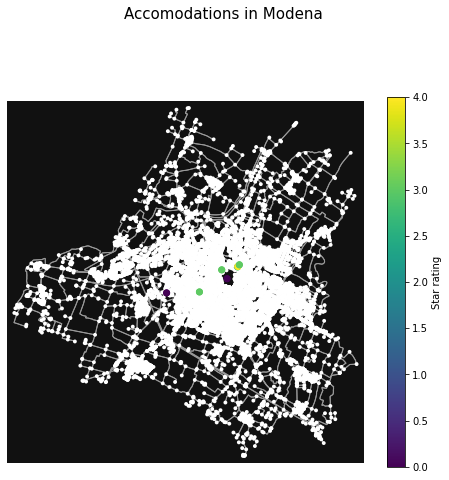

In [ ]:
fig, ax = ox.plot_graph(G, show=False, close=False)
plt.scatter(X.lon, X.lat, c=X.stars, cmap ='viridis')
plt.suptitle('Accomodations in '+ city, fontsize=15)
plt.colorbar(label ='Star rating', shrink=0.85)
plt.show()